In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., None]  # Add channel dimension
x_test = x_test[..., None]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def build_lenet5(input_shape):
    model = models.Sequential([
        layers.Conv2D(6, kernel_size=5, activation='relu', input_shape=input_shape),
        layers.AveragePooling2D(pool_size=2),
        layers.Conv2D(16, kernel_size=5, activation='relu'),
        layers.AveragePooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model


In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
input_shape = x_train.shape[1:]


In [12]:
for train_idx, val_idx in kf.split(x_train):
    train_data, val_data = x_train[train_idx], x_train[val_idx]
    train_labels, val_labels = y_train[train_idx], y_train[val_idx]

    model = build_lenet5(input_shape)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_data, train_labels,
        epochs=10, batch_size=64, verbose=1,
        validation_data=(val_data, val_labels)
    )

    val_acc = model.evaluate(val_data, val_labels, verbose=0)[1]
    fold_accuracies.append(val_acc)


Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6563 - loss: 0.9443 - val_accuracy: 0.8044 - val_loss: 0.5192
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8265 - loss: 0.4745 - val_accuracy: 0.8313 - val_loss: 0.4556
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8478 - loss: 0.4127 - val_accuracy: 0.8597 - val_loss: 0.3881
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8618 - loss: 0.3731 - val_accuracy: 0.8679 - val_loss: 0.3612
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8708 - loss: 0.3467 - val_accuracy: 0.8750 - val_loss: 0.3437
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8790 - loss: 0.3235 - val_accuracy: 0.8766 - val_loss: 0.3351
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8873 - loss: 0.3066 - val_accuracy: 0.8816 - val_loss: 0.3268
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8919 - loss: 0.2890 - val_accuracy: 0.

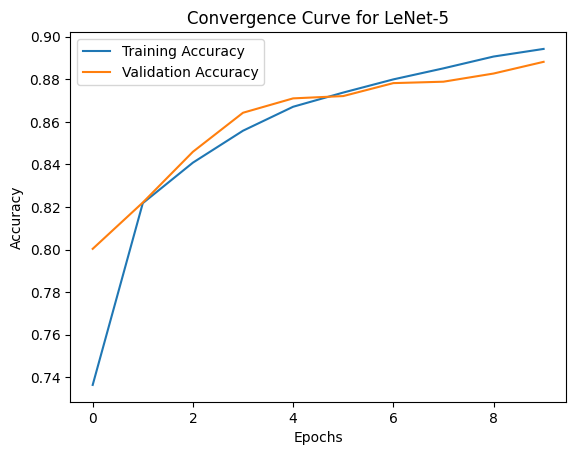

In [13]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Convergence Curve for LeNet-5')
plt.legend()
plt.show()


In [14]:
def build_transfer_model(base_model, input_shape):
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model


In [15]:
x_train_resized = np.repeat(x_train, 3, axis=-1)  # Convert to 3 channels
x_test_resized = np.repeat(x_test, 3, axis=-1)

In [19]:
from tensorflow.image import resize

# Resize the images to 32x32
x_train_resized = np.array([resize(img, (32, 32)).numpy() for img in x_train_resized])
x_test_resized = np.array([resize(img, (32, 32)).numpy() for img in x_test_resized])

# Check new shape
print(x_train_resized.shape)  # Should now be (num_samples, 32, 32, 3)


(60000, 32, 32, 3)


In [20]:
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
mobilenet_model = build_transfer_model(mobilenet_base, (32, 32, 3))


<ipython-input-20-d777cbad1acd>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


In [21]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg16_model = build_transfer_model(vgg16_base, (32, 32, 3))


In [22]:
mobilenet_model.compile(optimizer=Adam(learning_rate=0.001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

history_mobilenet = mobilenet_model.fit(x_train_resized, y_train, epochs=10, batch_size=64, verbose=1)
mobilenet_acc = mobilenet_model.evaluate(x_test_resized, y_test, verbose=0)[1]

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5660 - loss: 1.3101
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6469 - loss: 0.9685
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6715 - loss: 0.9039
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6810 - loss: 0.8670
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6924 - loss: 0.8340
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6944 - loss: 0.8203
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7021 - loss: 0.8048
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7094 - loss: 0.7889
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7162 - loss: 0.7683
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7185 - loss: 0.7606


In [23]:
vgg16_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
history_vgg16 = vgg16_model.fit(x_train_resized, y_train, epochs=10, batch_size=64, verbose=1)
vgg16_acc = vgg16_model.evaluate(x_test_resized, y_test, verbose=0)[1]

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7512 - loss: 0.7301
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8468 - loss: 0.4189
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8573 - loss: 0.3848
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8699 - loss: 0.3529
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8763 - loss: 0.3341
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8821 - loss: 0.3186
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8870 - loss: 0.3061
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8886 - loss: 0.3003
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8957 - loss: 0.2850
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8984 - loss: 0.2730


LeNet-5 Mean Accuracy (Cross-validation): 0.8895984833890741
MobileNetV2 Test Accuracy: 0.6811000108718872
VGG16 Test Accuracy: 0.8730999827384949


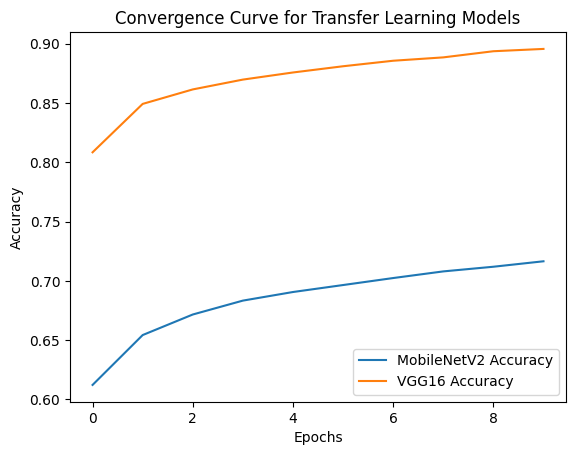

In [24]:
print("LeNet-5 Mean Accuracy (Cross-validation):", np.mean(fold_accuracies))
print("MobileNetV2 Test Accuracy:", mobilenet_acc)
print("VGG16 Test Accuracy:", vgg16_acc)

# Plot Transfer Learning Convergence Curves
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2 Accuracy')
plt.plot(history_vgg16.history['accuracy'], label='VGG16 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Convergence Curve for Transfer Learning Models')
plt.legend()
plt.show()


In [25]:
def build_transfer_model5(base_model, input_shape, fine_tune_at=None):
    if fine_tune_at is not None:
        # Freeze all layers up to the fine-tuning layer
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        # Unfreeze the rest
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True
    else:
        base_model.trainable = False  # Default: Freeze the entire base model

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model


In [27]:
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
mobilenet_model5 = build_transfer_model5(mobilenet_base, input_shape=(32, 32, 3), fine_tune_at=len(mobilenet_base.layers) - 10)

mobilenet_model5.compile(optimizer=Adam(learning_rate=0.001),  # Use a smaller learning rate for fine-tuning
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

history_mobilenet_model5 = mobilenet_model5.fit(x_train_resized, y_train, epochs=10, batch_size=64, verbose=1)
mobilenet_model5_acc = mobilenet_model5.evaluate(x_test_resized, y_test, verbose=0)[1]


<ipython-input-27-4155c8f70c92>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7353 - loss: 0.7971
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8215 - loss: 0.4914
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8343 - loss: 0.4425
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8438 - loss: 0.4181
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8499 - loss: 0.4003
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8615 - loss: 0.3672
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8711 - loss: 0.3455
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8742 - loss: 0.3337
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8799 - loss: 0.3152
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8889 - loss: 0.2916


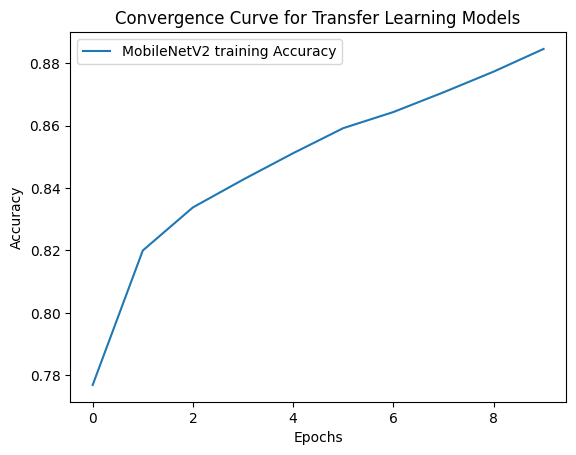

In [28]:
plt.plot(history_mobilenet_model5.history['accuracy'], label='MobileNetV2 training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Convergence Curve for Transfer Learning Models')
plt.legend()
plt.show()